# Logistic Regression

>> Model calibration ensures that the predicted probabilities faithfully represent the genuine likelihood of events, thereby enhancing the reliability of the model’s predictions. Logistic regression typically outputs well-calibrated probability estimates.



>> Evaluation of model outcomes made easy: https://github.com/ploomber/sklearn-evaluation



>> scikit-learn’s CalibratedClassifierCV handles multi-class scenarios using a one-vs-rest approach.

> Overly complex models might overfit (overconfidence) leading to poorly calibrated predictions.

> Extreme regularization has an effect on predictions - over-regularization can cause underconfident predictions.

> Resampling to address class imbalance also has an effect on probability estimates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
#print(dir(scipy))
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

In [ ]:
# create sample data
X, y = datasets.make_classification(1000, 10, n_informative = 5, class_sep = 0.4, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# fit model
clf = LogisticRegression(random_state = 42)
_ = clf.fit(X_train, y_train)

In [ ]:
#predicted probabilities
probas = clf.predict_proba(X_test)
probas[:5]

array([[0.65629161, 0.34370839],
       [0.39867937, 0.60132063],
       [0.64701085, 0.35298915],
       [0.72968007, 0.27031993],
       [0.47656574, 0.52343426]])


>> Each row in the output represents the probability of belonging to class 0 (first column) or class 1 (second column)

>> We expect a model to give a higher probability when it’s more confident about specific prediction. For example, if the probability of belonging to class 1 is 0.6, we might assume the model isn’t as confident as with one example whose probability estimate is 0.95. This is a property exhibited by well-calibrated models.

>> However, models do not always exhibit this property, so we must ensure our model is well-calibrated if we want to prioritize predictions or make confident decisions based on the model output.

In [ ]:
# get the probability to belonging to the positive class
prob_positive = probas[:, 1]

# dataframe with probabilities and actual labels
df = pd.DataFrame({'prob': prob_positive, 'actual': y_test})

# bin probabilities
df['prob_bin'] = pd.cut(df.prob, bins=np.arange(0, 1.1, 0.1))

df.head(5)

,prob,actual,prob_bin
0,0.343708,0,"(0.3, 0.4]"
1,0.601321,1,"(0.6, 0.7]"
2,0.352989,0,"(0.3, 0.4]"
3,0.270320,0,"(0.2, 0.3]"
4,0.523434,0,"(0.5, 0.6]"


In [ ]:
df.groupby('prob_bin').actual.mean()

<ipython-input-5-a61c525266c7>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('prob_bin').actual.mean()


,actual
prob_bin,
"(0.0, 0.1]",0.000000
"(0.1, 0.2]",0.000000
"(0.2, 0.3]",0.200000
"(0.3, 0.4]",0.290323
"(0.4, 0.5]",0.514286
"(0.5, 0.6]",0.526316
"(0.6, 0.7]",0.608696
"(0.7, 0.8]",0.900000
"(0.8, 0.9]",0.875000


>> We see that the model is reasonably calibrated. No sample belongs to the positive class for outputs between 0.0 and 0.1. Also, for the ones between 0.3 and 0.4, 29% belong to the positive class.


> It is hard to evaluate the numbers in a table; this is where a calibration curve helps, allowing us to assess calibration visually.

>> A perfectly calibrated model will output a score of 0.1 when it’s 10% confident that the model belongs to the positive class, 0.2 when it’s 20%, and so on. If we draw this, we’d have a straight line that is, ideally a well-calibrated model produces predicted probabilities that match the observed frequencies of the positive outcomes across different probability intervals.



# SVM

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


In [ ]:
def compute_scores(y_true, y_pred_proba, name = None):

  scores = {
        'brier_score': brier_score_loss(y_true, y_pred_proba),
        'log_loss_score': log_loss(y_true, y_pred_proba),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
  return pd.Series(scores).rename(name)


In [ ]:
X, y = make_classification(n_samples = 10000, n_classes = 2, weights = [0.7, 0.3], random_state = 42)  #binary #imbalance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Train an SVM classifier
clf = SVC(kernel = 'rbf', random_state = 42)
clf.fit(X_train, y_train)


# probability predictions
y_pred_proba = clf.decision_function(X_test)
y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

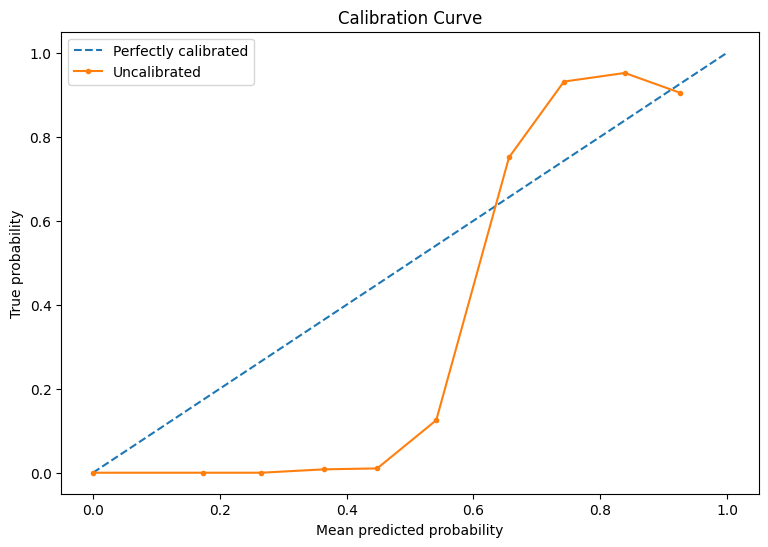

In [ ]:
#for calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins = 10) #strategy = how the bins are created, for example 'quantile' means equal-freq.

# Calibration plot
plt.figure(figsize = (9, 6))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker = '.', label = 'Uncalibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
# Compute metrics
print(compute_scores(y_test, y_pred_proba, name = 'Uncalibrated'))

brier_score       0.177542
log_loss_score    0.539588
roc_auc           0.968339
Name: Uncalibrated, dtype: float64


In [ ]:
# Calibrate using Platt Scaling
clf_platt = CalibratedClassifierCV(clf, cv=5, method = 'sigmoid')
clf_platt.fit(X_train, y_train)

# Calibrate using Isotonic Regression
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method = 'isotonic')
clf_isotonic.fit(X_train, y_train)

# calibrated probability predictions
y_pred_proba_platt = clf_platt.predict_proba(X_test)[:, 1]
y_pred_proba_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

In [ ]:
prob_true, prob_pred_uncal = calibration_curve(
    y_test, y_pred_proba, n_bins=10, strategy = 'quantile')

prob_true_platt, prob_pred_platt = calibration_curve(
    y_test, y_pred_proba_platt, n_bins=10, strategy = 'quantile')

prob_true_isotonic, prob_pred_isotonic = calibration_curve(
    y_test, y_pred_proba_isotonic, n_bins=10, strategy = 'quantile')

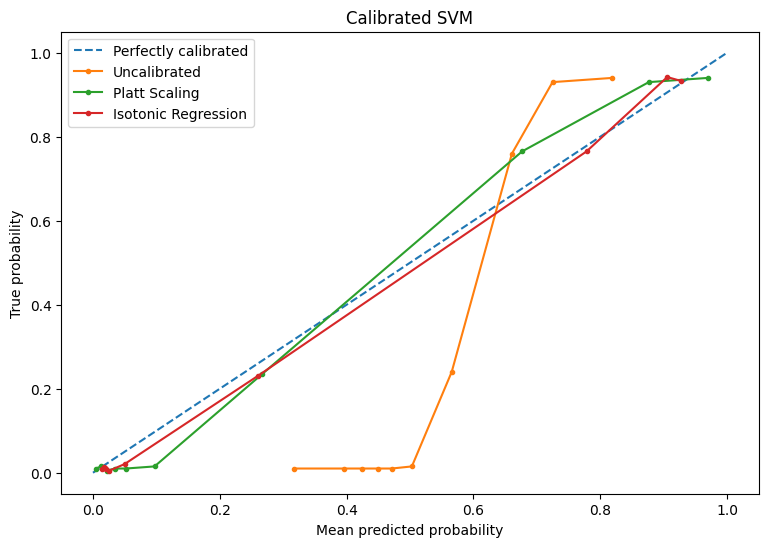

In [ ]:
# Calibration plot
plt.figure(figsize = (9, 6))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly calibrated')
plt.plot(prob_pred_uncal, prob_true, marker = '.', label = 'Uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker = '.', label = 'Platt Scaling')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker = '.', label = 'Isotonic Regression')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibrated SVM')
plt.legend()
plt.show()

In [ ]:
# Compute metrics
df_scores = pd.DataFrame([
    compute_scores(y_test, y_pred_proba, name = 'Uncalibrated'),
    compute_scores(y_test, y_pred_proba_platt, name = 'Platt Scaling'),
    compute_scores(y_test, y_pred_proba_isotonic, name = 'Isotonic Regression')])
print(df_scores)

                     brier_score  log_loss_score   roc_auc
Uncalibrated            0.177542        0.539588  0.968339
Platt Scaling           0.053869        0.202653  0.968106
Isotonic Regression     0.051877        0.188629  0.967950


> Platt Scaling and Isotonic Regression significantly improves the calibration of SVM's probability estimates.

>> scikit-learn’s CalibratedClassifierCV handles multi-class scenarios using a one-vs-rest approach.

# Random Forest

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

# Convert the multiclass problem into a binary classification problem
# Let’s consider class 1 (Iris-Versicolour) as the positive class

y_binary = np.where(y == 1, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size = 0.2, random_state = 42)

In [ ]:
#Train RF classifier model
rf_classifier = RandomForestClassifier(n_estimators = 100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_proba = rf_classifier.predict_proba(X_test)

In [ ]:
#prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins = 10, pos_label = 1)

In [ ]:
rf_platt = CalibratedClassifierCV(rf_classifier, cv = 5, method = 'sigmoid')  #Platt scaling
rf_platt.fit(X_train, y_train)

rf_isotonic = CalibratedClassifierCV(rf_classifier, cv = 5, method = 'isotonic')
rf_isotonic.fit(X_train, y_train)


CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(),
                       method='isotonic')

In [ ]:
# calibrated probability predictions
y_pred_proba_platt = rf_platt.predict_proba(X_test)[:, 1]
y_pred_proba_isotonic = rf_isotonic.predict_proba(X_test)[:, 1]

prob_true_platt, prob_pred_platt = calibration_curve(
    y_test, y_pred_proba_platt, n_bins = 10, strategy = 'quantile')  #equal #sample in each bin

prob_true_isotonic, prob_pred_isotonic = calibration_curve(
    y_test, y_pred_proba_isotonic, n_bins = 10, strategy = 'quantile')

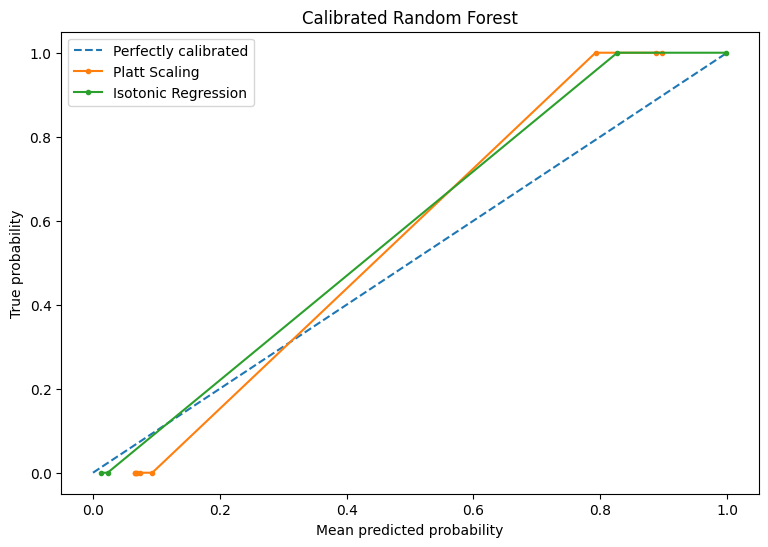

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly calibrated')
#plt.plot(prob_pred_uncal, prob_true, marker = '.', label = 'Uncalibrated')
#plt.plot(prob_pred, prob_true, marker = 'o', linestyle = '-', color = 'b', label = 'Uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker = '.', label = 'Platt Scaling')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker = '.', label = 'Isotonic Regression')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibrated Random Forest')
plt.legend()
plt.show()

In [ ]:
def compute_scores(y_true, y_pred_proba, name = None):

  scores = {
        'brier_score': brier_score_loss(y_true, y_pred_proba),
        'log_loss_score': log_loss(y_true, y_pred_proba)}

  return pd.Series(scores).rename(name)

print(pd.DataFrame([
    compute_scores(y_test, y_pred_proba_platt, name = 'Platt Scaling'),
    compute_scores(y_test, y_pred_proba_isotonic, name = 'Isotonic Regression')]))

                     brier_score  log_loss_score
Platt Scaling           0.010344        0.098280
Isotonic Regression     0.003362        0.029237


> Probability calibration allows us to ensure that higher scores from trained model are more likely to belong to the positive class.